# Import Useful Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from enterprise.pulsar import Pulsar
from enterprise_extensions import blocks
import pickle, glob
import NimaClass as nc
from astropy.coordinates import SkyCoord
from astropy import units as u
from enterprise.signals import gp_signals, signal_base
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from enterprise_extensions import sampler as samp
import sim
import corner
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plotting Settings

Note: If you do not like a dark_background for your plots, do not run `plt.style.use('dark_background')`

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')
hist_settings = dict(
    bins = 40,
    histtype = 'step',
    lw = 3,
    density = True
)

# <center>ENTERPRISE: a PTA Data Analysis Tool

## Input

### In case you have par & tim files:

In [32]:
#psrs = []
# # Path to tim file(s)
#timfiles = sorted(glob.glob('...' + '/*.tim'))
#  Path to par file(s)
#parfiles = sorted(glob.glob('...'+ '/*.par'))
#for p, t in zip(parfiles, timfiles):
#     psrs.append(Pulsar(p, t, ephem = None , clk=None))

### In case you have a pickle file of the psrs object

In [4]:
with open('/home/gourliek/Desktop/gw-school-2024-materials/Day_3/Tutorials/data/sim_ng_psrs.pkl', 'rb') as fin:
    psrs = pickle.load(fin)
psrs

## Exploring the `psrs` object 

In [5]:
## all the atributes of the psrs object
dir(psrs[0])

['Mmat',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_decj',
 '_deflated',
 '_designmatrix',
 '_dm',
 '_flags',
 '_get_pdist',
 '_get_planetssb',
 '_get_pos',
 '_get_radec',
 '_get_radec_from_ecliptic',
 '_get_sunssb',
 '_iisort',
 '_isort',
 '_pdist',
 '_planetssb',
 '_pos',
 '_pos_t',
 '_raj',
 '_residuals',
 '_set_dm',
 '_sort',
 '_ssbfreqs',
 '_stoas',
 '_sunssb',
 '_telescope',
 '_toaerrs',
 '_toas',
 '_todeflate',
 'backend_flags',
 'deflate',
 'destroy',
 'dm',
 'dmx',
 'filter_data',
 'fitpars',
 'flags',
 'freqs',
 'iisort',
 'inflate',
 'isort',
 'name',
 'pdist',
 'phi',
 'planets',
 'planetssb',
 'pos',
 'pos_t',
 'residuals',
 'set_flags',
 'setpars',

In [6]:
## number of pulsars
Npulsars = len(psrs)
Npulsars

45

In [7]:
## name of the pulsars
psrlist = [psr.name for psr in psrs]
psrlist

['B1855+09',
 'B1937+21',
 'B1953+29',
 'J0023+0923',
 'J0030+0451',
 'J0340+4130',
 'J0613-0200',
 'J0636+5128',
 'J0645+5158',
 'J0740+6620',
 'J0931-1902',
 'J1012+5307',
 'J1024-0719',
 'J1125+7819',
 'J1453+1902',
 'J1455-3330',
 'J1600-3053',
 'J1614-2230',
 'J1640+2224',
 'J1643-1224',
 'J1713+0747',
 'J1738+0333',
 'J1741+1351',
 'J1744-1134',
 'J1747-4036',
 'J1832-0836',
 'J1853+1303',
 'J1903+0327',
 'J1909-3744',
 'J1910+1256',
 'J1911+1347',
 'J1918-0642',
 'J1923+2515',
 'J1944+0907',
 'J2010-1323',
 'J2017+0603',
 'J2033+1734',
 'J2043+1711',
 'J2145-0750',
 'J2214+3000',
 'J2229+2643',
 'J2234+0611',
 'J2234+0944',
 'J2302+4442',
 'J2317+1439']

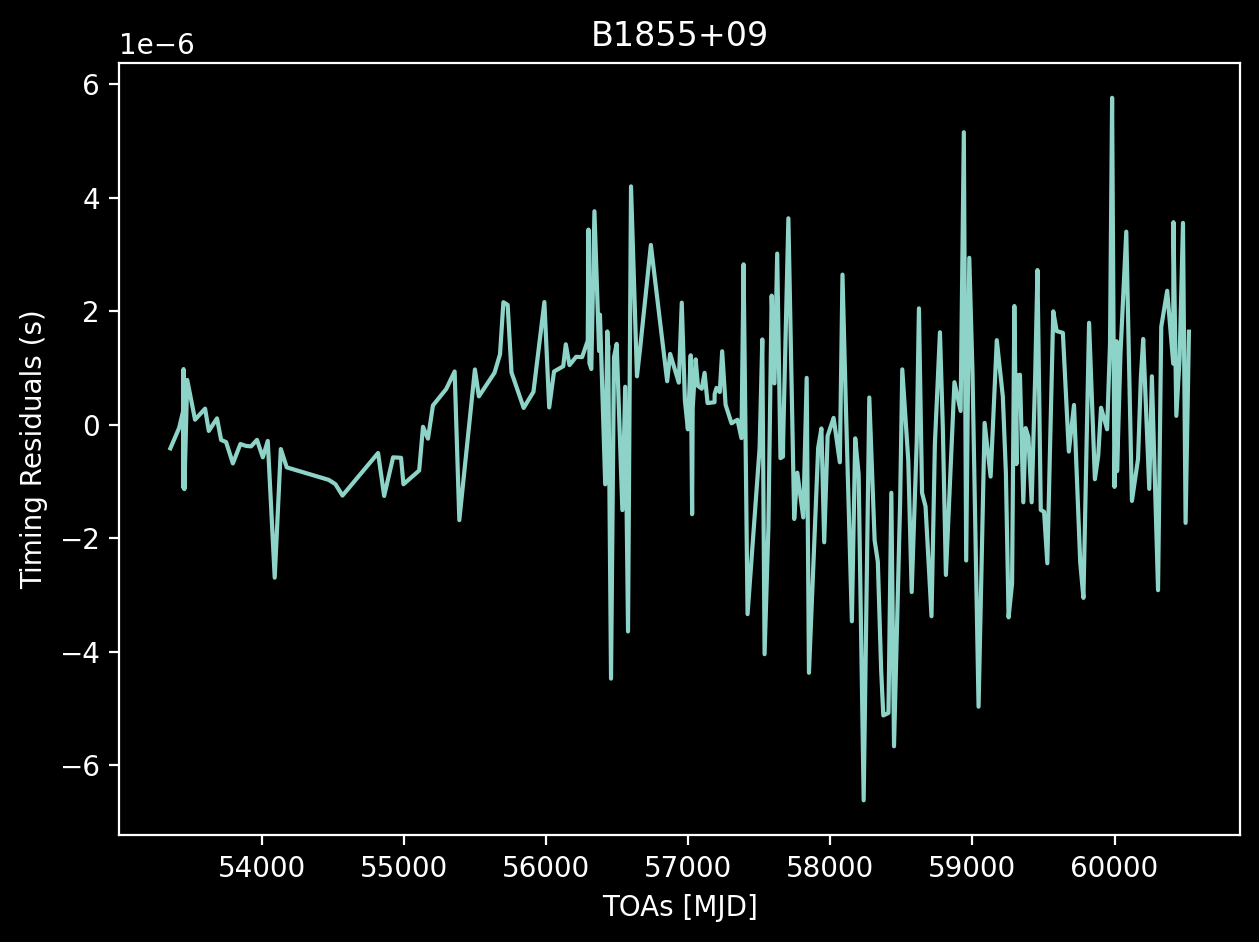

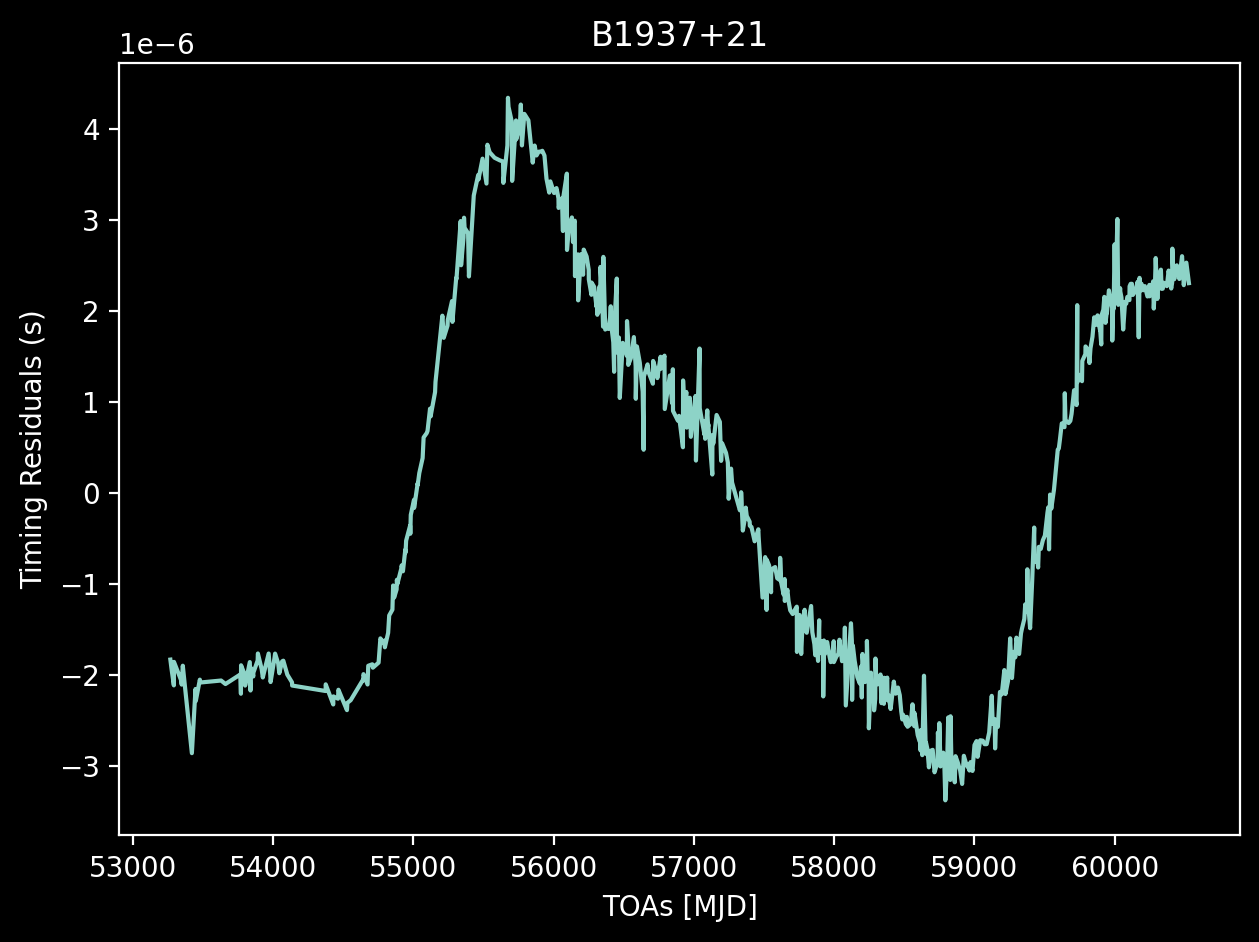

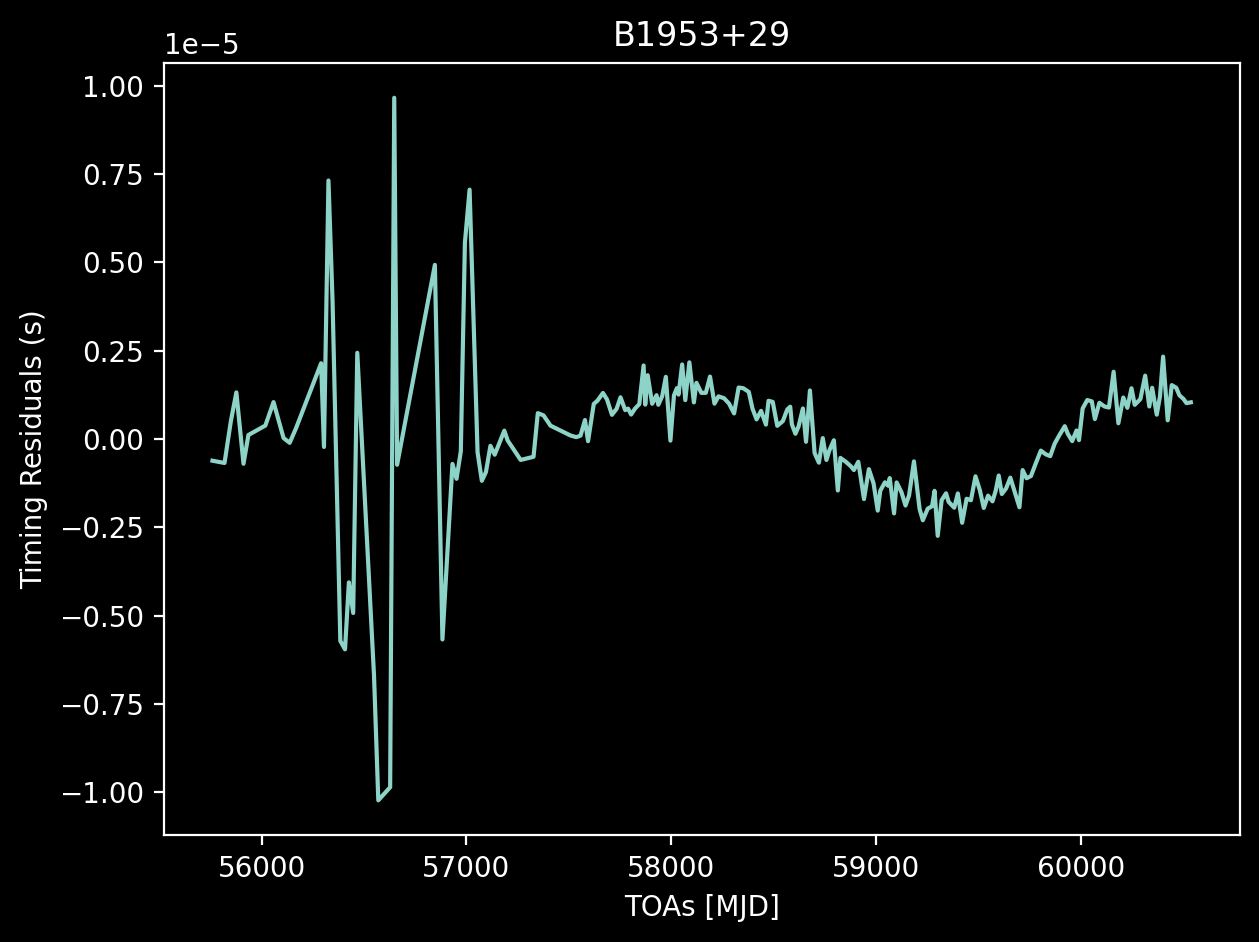

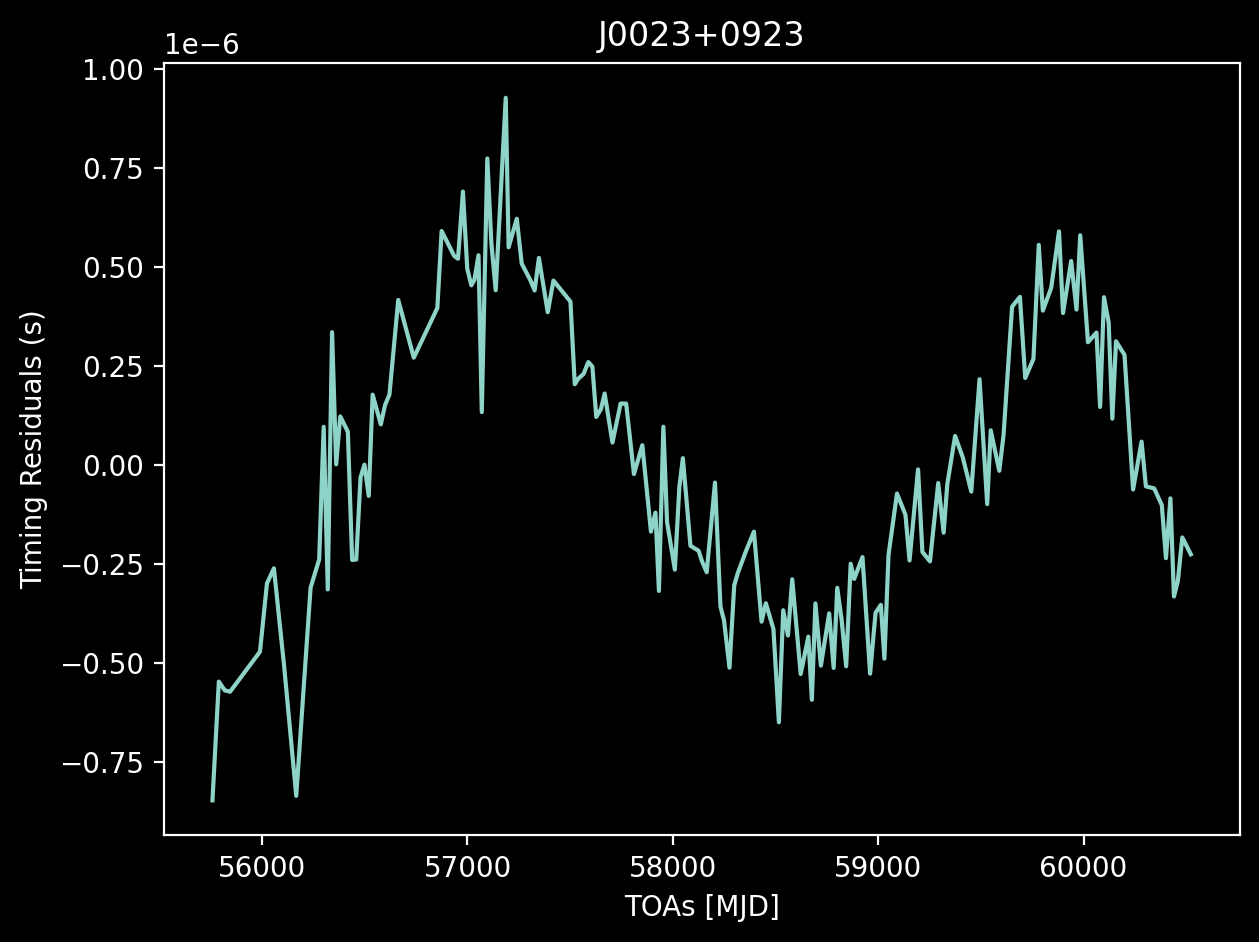

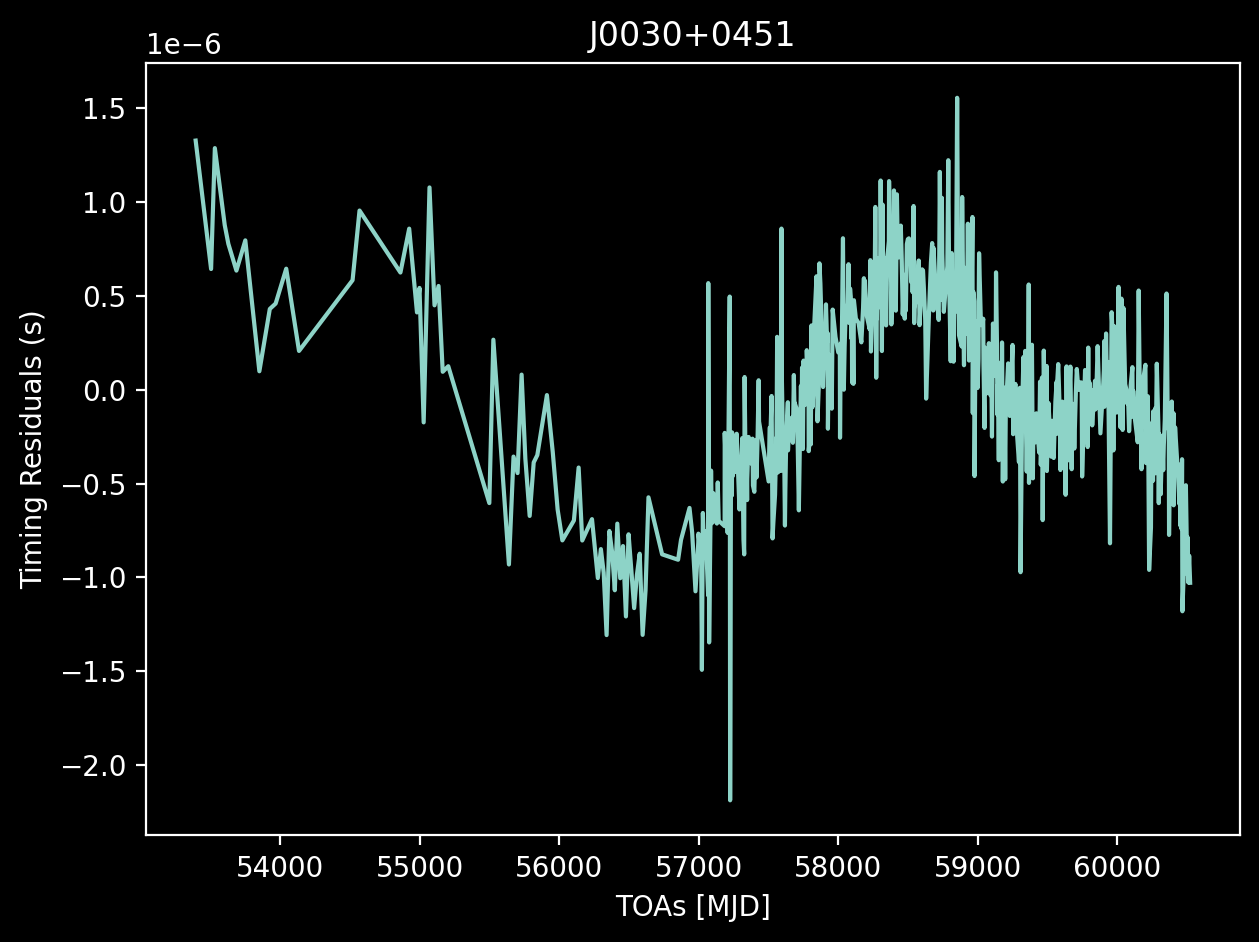

In [8]:
## toas and residuals
for psr in psrs[:5]:
    plt.plot(psr.toas/(86400), psr.residuals)
    plt.title(psr.name)
    plt.xlabel('TOAs [MJD]')
    plt.ylabel('Timing Residuals (s)')
    plt.tight_layout()
    plt.show()

In [9]:
## pulsars' sky location
dec = np.array([psr._decj for psr in psrs])
ra = np.array([psr._raj for psr in psrs])

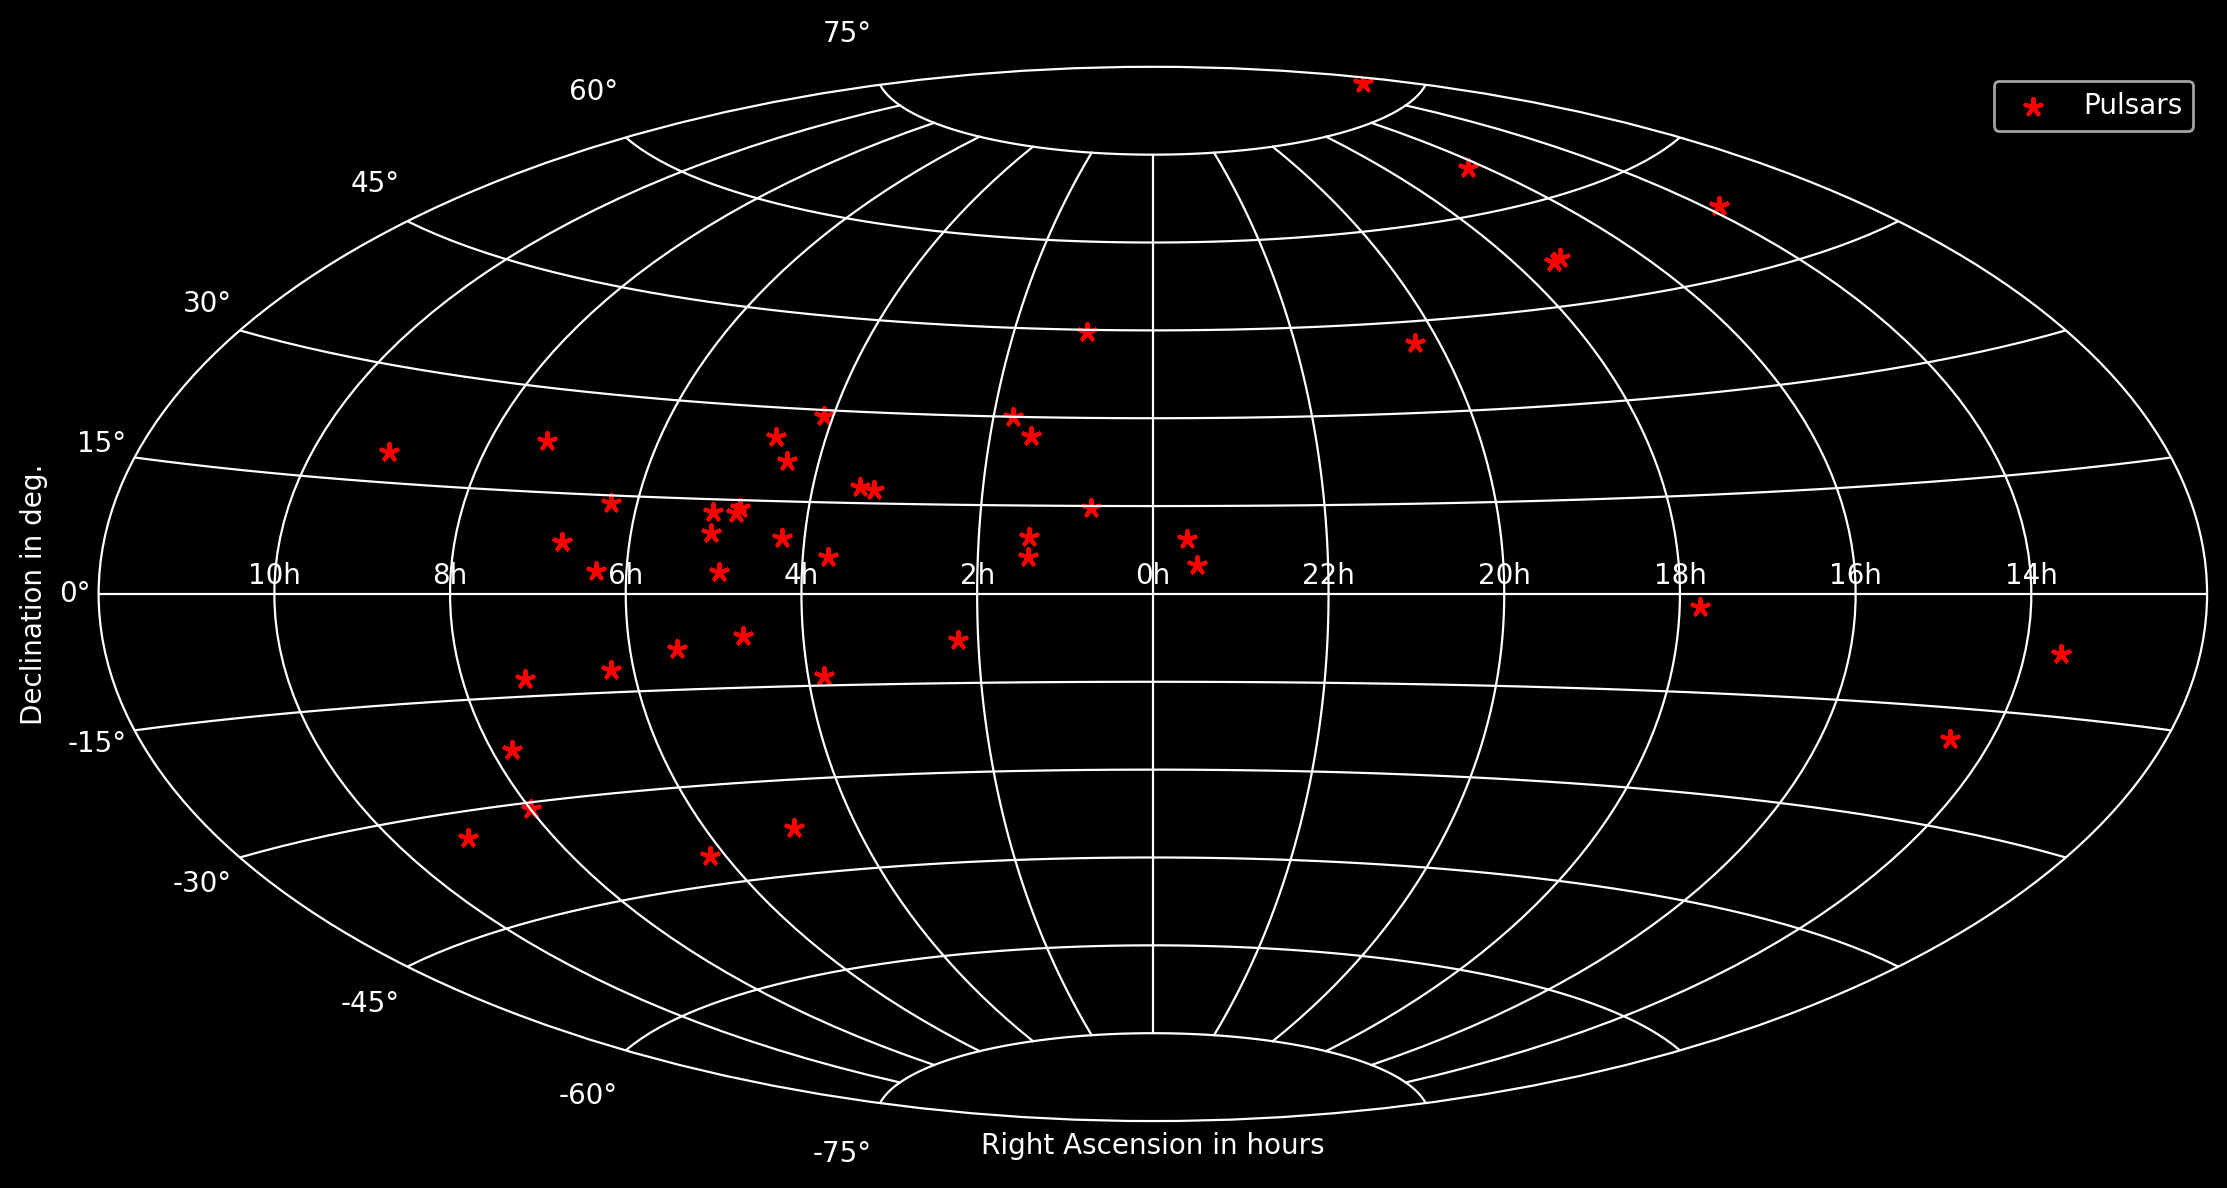

In [10]:
sc = SkyCoord(ra = ra , dec = dec, unit = 'rad', frame='icrs')
plt.figure(figsize=(12, 6))
plt.subplot(projection="aitoff")

c = SkyCoord(ra*180/np.pi, dec*180/np.pi, unit = 'deg', frame='icrs')
ra_rad = c.ra.wrap_at(180 * u.deg).radian
dec_rad = c.dec.radian
plt.scatter(ra_rad  , dec_rad,marker=(5, 2),color = 'r',label = 'Pulsars')

plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                                30, 60, 90, 120, 150]),
            labels=['10h', '8h', '6h', '4h', '2h', '0h', \
                    '22h', '20h', '18h', '16h', '14h'])

plt.xlabel('Right Ascension in hours')
plt.ylabel('Declination in deg.')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

In [11]:
## Pulsar distances and their error (mean, std)
[psr.pdist for psr in psrs]

[(0.9, 0.2),
 (5.0, 2.0),
 (5.39, 1.1),
 (1.0, 0.2),
 (0.28, 0.1),
 (1.0, 0.2),
 (0.9, 0.4),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (0.7, 0.2),
 (0.49, 0.12),
 (1.0, 0.2),
 (1.0, 0.2),
 (0.74, 0.15),
 (2.4, 0.9),
 (1.0, 0.2),
 (1.19, 0.238),
 (0.42, 0.09),
 (1.05, 0.06),
 (1.0, 0.2),
 (1.0, 0.2),
 (0.42, 0.02),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.26, 0.03),
 (1.95, 0.39),
 (1.0, 0.2),
 (1.4, 0.28),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (0.57, 0.11),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.0, 0.2),
 (1.89, 0.38)]

In [12]:
## TOA errors in seconds
[psr.toaerrs for psr in psrs]

[array([8.21180e-07, 1.77930e-07, 1.98610e-07, 8.17000e-07, 8.19210e-07,
        8.16030e-07, 6.15920e-07, 8.67430e-07, 9.15560e-07, 3.87070e-07,
        1.93410e-07, 1.66100e-07, 9.67300e-08, 1.17030e-07, 2.72350e-07,
        1.27240e-07, 2.61260e-07, 1.60860e-07, 2.43280e-07, 3.62650e-07,
        2.42530e-07, 2.80290e-07, 1.17170e-07, 8.14050e-07, 1.96110e-07,
        8.76040e-07, 2.60310e-07, 2.22550e-07, 4.51440e-07, 3.56940e-07,
        3.42390e-07, 2.23210e-07, 1.81390e-07, 8.24830e-07, 9.36700e-07,
        8.40170e-07, 8.30260e-07, 8.71800e-07, 1.00416e-06, 8.41990e-07,
        1.12316e-06, 8.24110e-07, 8.83800e-07, 8.49580e-07, 8.88990e-07,
        8.72980e-07, 8.82150e-07, 5.71790e-07, 2.96450e-07, 4.25350e-07,
        2.02890e-07, 2.19879e-06, 2.19556e-06, 2.40390e-07, 2.32810e-07,
        2.69830e-07, 2.34080e-07, 2.34990e-07, 2.38760e-07, 2.43410e-07,
        2.19659e-06, 2.46110e-07, 2.46820e-07, 2.19857e-06, 2.28090e-07,
        2.19621e-06, 2.19641e-06, 2.33930e-07, 2.28

In [13]:
## The observing baseline for each pulsar (in years)
tspans = np.array([(psr.toas.max() - psr.toas.min())/(86400 * 365.25) for psr in psrs])
tspans

array([19.61553951, 19.88386037, 13.07961551, 13.04387035, 19.51900011,
       12.51381619, 19.36585837, 10.62819041, 13.19077171, 10.6564222 ,
       11.41969619, 20.05824211, 14.82634518, 10.65891428, 11.03925762,
       20.06141982, 16.7728371 , 15.88548734, 19.44448269, 19.83396916,
       19.51772217, 14.75459153, 13.05150141, 20.03885741, 12.48657664,
       11.45566901, 13.14618083, 14.77047734, 19.80923585, 15.45826023,
       11.05251678, 19.80513002, 12.97354426, 16.58489963, 14.88651998,
       12.44574529, 10.99226326, 13.07301331, 19.87300691, 12.83711162,
       11.05023234, 10.57382013, 11.15134373, 12.48551647, 19.61854761])

# <center>PTA Detection Terminology

The goal of detection is to assess the statistical significance of various types of <span style="color:red">red noise processes</span>. To achieve this goal, we need to make sure we understand a few topics defined within the context of pulsar timing experiments.

## Topic 1: What is a noise process?

A noise process is a series of random numbers which are completely independent of each other. This means you cannot predict the future given the past, in complete contrast to deterministic processes. 

We deal with two types of noise processes:
1. White (Gaussian) Noise: random numbers drawn from a Gaussian distribution with the property that their spectral power is constant across all frequencies.
2. Red Noise: a linear combination of white noise processes filtered in a way that its spectral power decreases with increasing frequencies.

In case you are not familiar with spectral power, you can think of it as a measure of the strength of the signal that the series of random numbers represent. This power is defined in the frequency domain. It is an extremely important quantity!

### White Noise

$\Large w_{\underbrace{I}_{\text{pulsar index}}}$

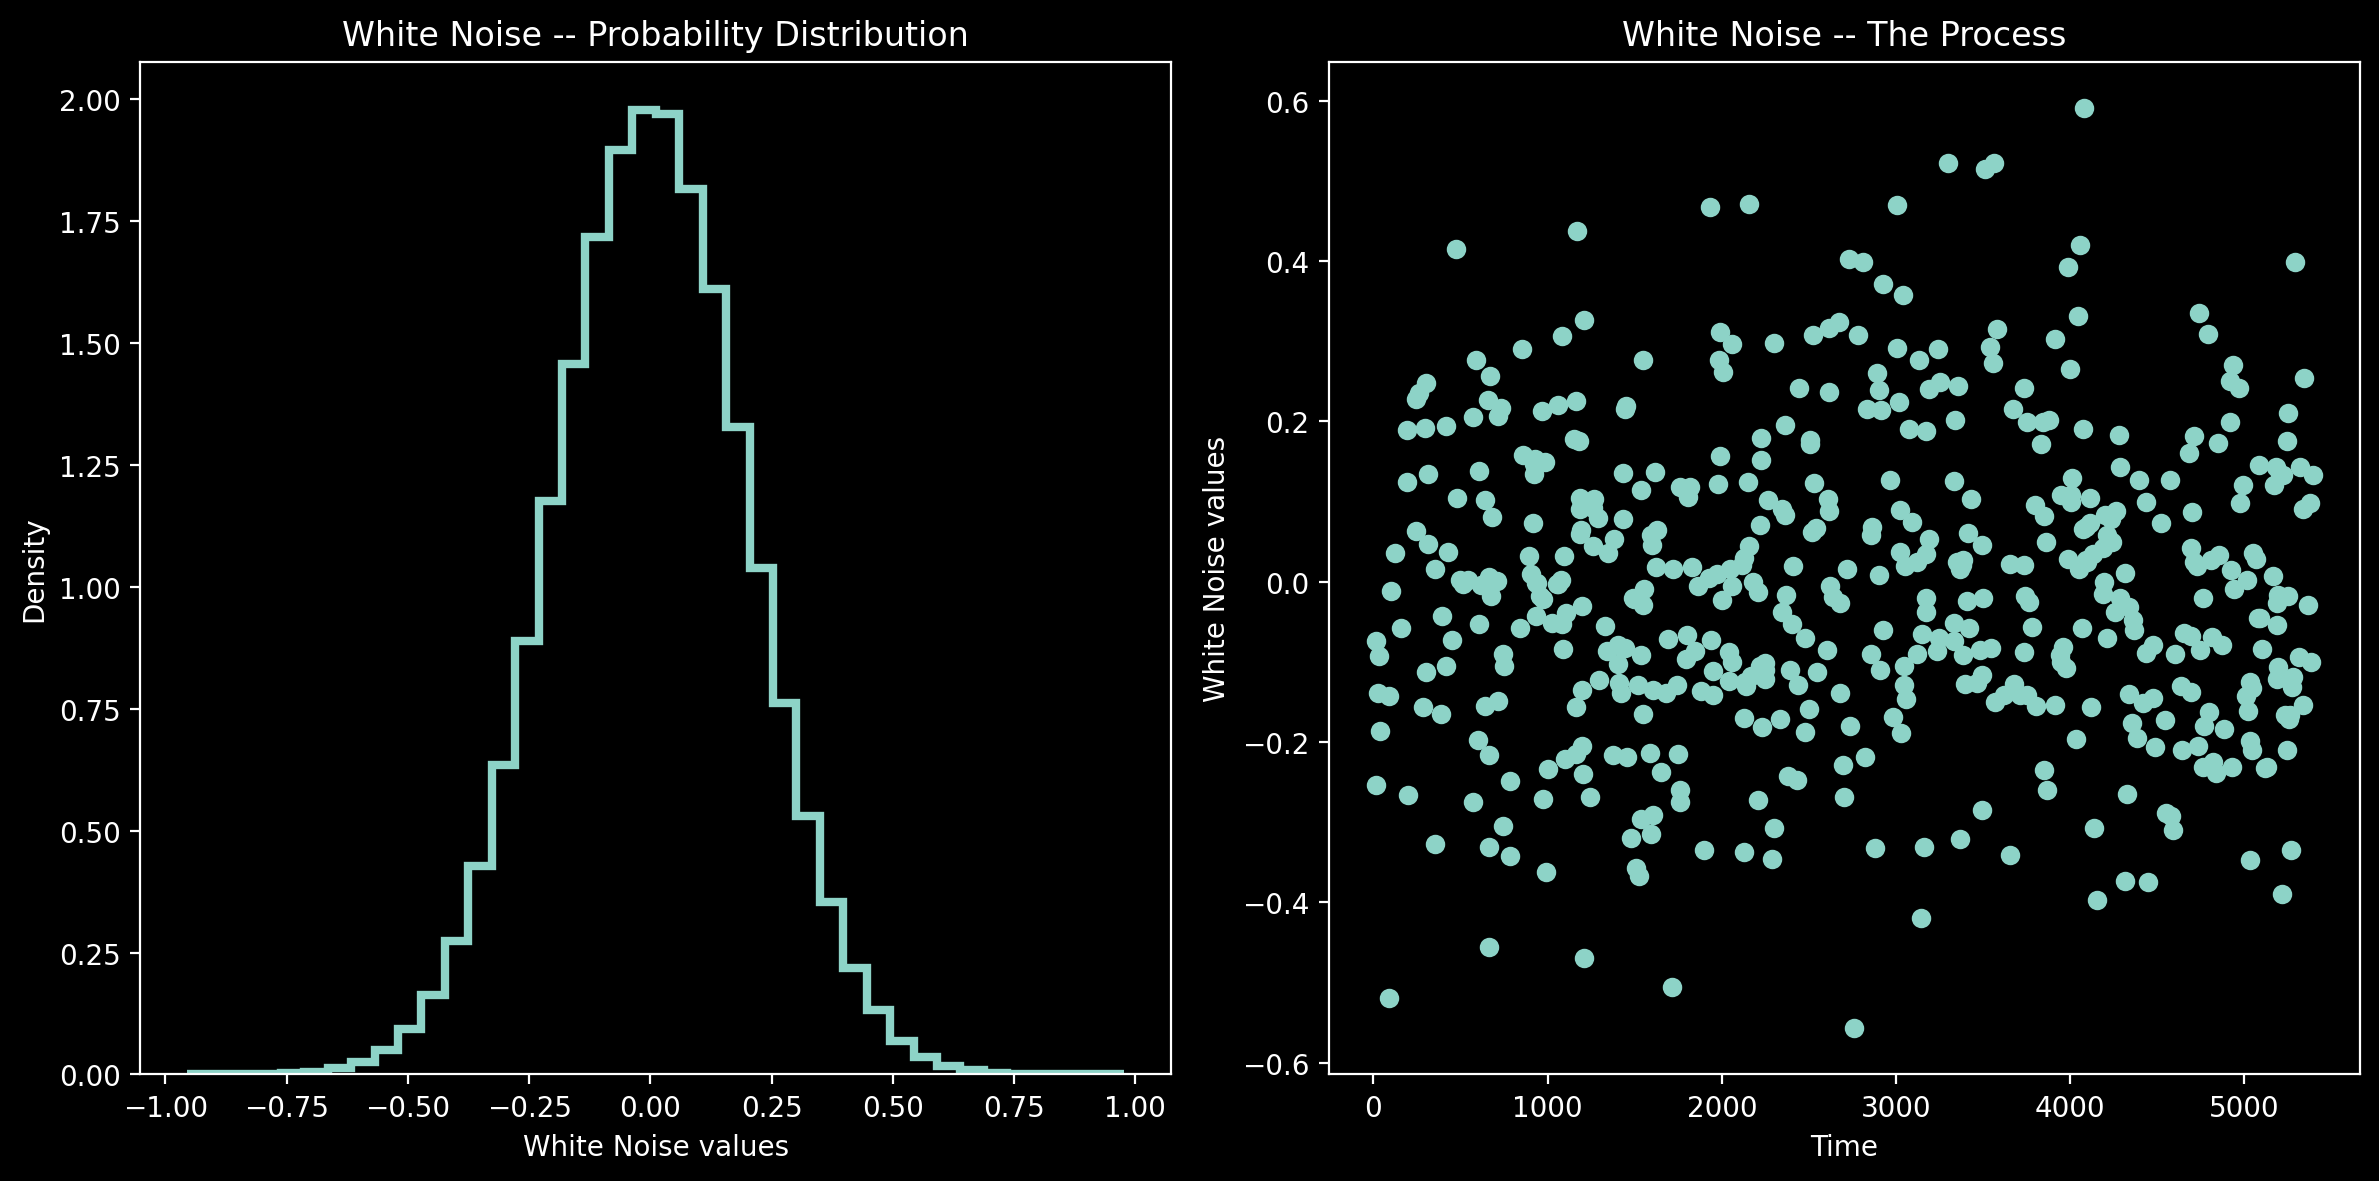

In [14]:
draws = int(1e6)
wn = np.random.normal(loc = 0, scale = .2, size = draws)
t = np.linspace(0, 5400, draws)

idxs = np.random.randint(0, draws, 500)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (6*2, 6))
ax[0].hist(wn, **hist_settings)
ax[0].set_title('White Noise -- Probability Distribution')
ax[1].scatter(t[idxs], wn[idxs])
ax[1].set_title('White Noise -- The Process')
ax[0].set_xlabel('White Noise values')
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Density')
ax[1].set_ylabel('White Noise values')
plt.tight_layout()
plt.show()

### Red Noise
$\Large r_I(f) = c_I(f)w_I(f)$

$\Large {\underbrace{c_I}_{\text{filtering function that sets the spectral power}}}$

### Note:

1. When dealing with noise, the concept of <span style="color:red">realization</span> becomes important. One can construct infinite number of unique-looking signals in the time-domain all of which possessing the same spectral properties (e.g., identical spectral power). A realization of a noise process is one out of infinite number of such possibilities. When doing computation, changing the seed of a random number generator changes the realization of the noise process made out of the random numbers.

2. The mean of a red noise process is not zero, unlike a white noise process, if you take the mean over a single realization. In theory, a true red noise process is a zero-mean process if the mean is taken over many realizations. Make sure you understand the difference between them!

## Topic 2: What is a common red noise process?
$\Large r_I(f) = c(f)w_I(f)$

Definition: If different realizations of the same red noise process exist between different pulsars' timing residuals, the process is called a common red noise process. 

Question: How to go about checking if multiple realizations of the same red noise process exist in different pulsars? What statistical quantity could reveal such information?

Note: note the difference between how $r_I$ is defined as a common red noise versus as a red noise.

## Topic 3: What is a common correlated red noise process?

$\Large r_I(f) = c(f)\sum_{J}\Gamma_{IJ}w_J(f)$

$\Large {\underbrace{\Gamma_{IJ}}_{\text{a non-diagonal matrix}}}$

Definition: if a pair of two different realizations of the same red noise process are correlated, the red noise process between the pair is called a common correlated red noise process. 

If the non-diagonal elements of the matrix $\large \Gamma$ depend on pulsar pairs' angular separation, the correlation is called spatial correlation. This type of correlation is searched for in PTA GWB analyses.

## Topic 4: What is an intrinsic red noise process?

Definition: a red noise process that is not common between pulsars

## Topic 5: What is spectral power?

Spectral power, power spectral density, and PSD all refer to the same quantity. As described earlier, PSD is a measure of a noise process's strength defined in the frequency domain. Mathematically,

$\Large \langle r_I(f)r_I^*(f')\rangle  = \delta(f-f') \times \text{PSD} $,

where $\delta$ is the kronecker delta function.

You can model a red noise's PSD in any shape you want as long as the value of PSD decreases with increasing frequency. The two simplest and the most used models are 
1. Powerlaw model

2. Free spectral model
The choice for the way you model PSD of a red noise process could be astrophysically motivated. You will hear about this in future tutorials!

### Powerlaw Model of PSD

$\Large P(f_k) = \frac{A^2}{12 \pi^2 f_k^3} \left( \frac{f_k}{f_{\text{ref}}}\right)^{3-\gamma},$

$k$ is the frequency index, $A$ is the amplitude, $f_\text{ref}$ is the reference frequency (typically 1/1yr), and $\gamma$ is the spectral index which must be a positive number.

### Free-spectral Model of PSD

$\Large P(f_k) = T_{\text{obs}}\rho_k^2$

$T_{\text{obs}}$ is the observational time and $\rho_k^2$ is the value of PSD at frequency-bin $k$. Notice the difference between a powerlaw model and a free-spectral model. In a free-spectral model, each frequency-bin is allowed to have its own PSD independent of other bins.

## Noise Modeling Using ENTERPRISE

$\Large R(t) = M \epsilon + Fa + \text{WN} $

### Timing Model

When we construct a timing model for a pulsar, we have uncertainties about our model. This uncertainty $\epsilon$ needs to be taken into consideration in any noise modeling that we do.
The matrix $M$ is the design-matrix containing the bases of the timing model parameters.

In [15]:
tm = gp_signals.MarginalizingTimingModel(use_svd=True)

### White Noise

In [16]:
## Do you need to vary the parameters that describe white noise (EFAC, EQUAD, and ECORR are the params)?
vary = False
if not vary:
    noise_dict = {}
    for pname in psrlist:
        noise_dict.update({pname + '_efac': 1.0})   #simple gaussian white noise
        noise_dict.update({pname + '_log10_t2equad': -np.inf})   #does not exist within the model
## Do you need to include ECORR noise (do not worry if you do not know what ECORR is!)?
inc_ecorr = False
## Do you want to use different backends for the telescopes?
select = 'none'

wn = blocks.white_noise_block(vary = vary, inc_ecorr = inc_ecorr, select = select)

### Intrinsic Red Noise

In [17]:
## How do you want to model the spectral power of your red noise? 
psd = 'powerlaw'
## What do you know about the prior for the parameters that describe the red noise?
prior = 'log-uniform'
## What frequencies do you want to consider in your model? It must be in seconds.
number_of_bins = 30
observing_time_to_use_in_freq_calculation = tspans.max() * 86400 * 365.25

rn = blocks.red_noise_block(psd=psd, prior=prior, Tspan=observing_time_to_use_in_freq_calculation,
                            components=number_of_bins)

### Common Red Noise

In [18]:
## How do you want to model the spectral power of your red noise? 
psd = 'powerlaw'
## What do you know about the prior for the parameters that describe the red noise?
prior = 'log-uniform'
## What frequencies do you want to consider in your model? It must be in seconds.
number_of_bins = 5
observing_time_to_use_in_freq_calculation = tspans.max() * 86400 * 365.25

crn = blocks.common_red_noise_block(psd=psd, prior=prior, 
                                    Tspan=observing_time_to_use_in_freq_calculation, 
                                    components=number_of_bins,
                                    name = 'crn')


### Common Correlated Red Noise

In [19]:
## How do you want to model the spectral power of your red noise? 
psd = 'powerlaw'
## What do you know about the prior for the parameters that describe the red noise?
prior = 'log-uniform'
## What frequencies do you want to consider in your model? It must be in seconds.
number_of_bins = 5
observing_time_to_use_in_freq_calculation = tspans.max() * 86400 * 365.25
## What functional shape do you want the correlations to follow?
corr = 'hd'

ccrn = blocks.common_red_noise_block(psd=psd, prior=prior, 
                                    Tspan=observing_time_to_use_in_freq_calculation, 
                                    components=number_of_bins, orf = corr,
                                    name = 'gw')


### Build the Model

In [20]:
# data = tm + wn + rn
#data = tm + wn + crn
#data = tm + wn + ccrn
data = tm + wn + rn + crn


In [21]:
## How many pulsars do you want to consider in your model?
psrs_to_choose = psrs[:]
## Build the model
pta = signal_base.PTA([data(p) for p in psrs_to_choose])
## You need to fix the white noise parameters if you chose not to vary them when defining `wn`
if not vary:
    pta.set_default_params(noise_dict)

In [22]:
pta.params

[B1855+09_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1855+09_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 B1937+21_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1937+21_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 B1953+29_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1953+29_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0023+0923_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0023+0923_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0030+0451_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0030+0451_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0340+4130_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0340+4130_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0613-0200_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0613-0200_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0636+5128_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0636+5128_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0645+5158_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0645+5158_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J07

### Calculate the log-liklihood of the model 

In [23]:
x0 = np.hstack([p.sample() for p in pta.params])
pta.get_lnlikelihood(x0)

KernelMatrix(159742.24365192)

# MCMC Sampler

In [24]:
## Output directory
outdir = './Chain'

## Jump Proposals, groups, and MCMC Tunings
ndim = len(x0)
cov = np.diag(np.ones(ndim) * 0.01**2) # helps to tune MCMC proposal distribution

pars = pta.param_names
idx_orf_params0 = [list(pars).index(pp) for pp in pars if 'crn' in pp]
groups = [list(np.arange(0, ndim))]
[groups.append(idx_orf_params0) for ii in range(5)]

## Initiate the sampler
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups = groups,
                 outDir=outdir, 
                 resume=False)

jp = samp.JumpProposal(pta)
sampler.addProposalToCycle(jp.draw_from_prior, 15)
sampler.addProposalToCycle(jp.draw_from_red_prior, 15)

## Number of MCMC steps
N = int(1e5)

In [26]:
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 10.00 percent in 52.808821 s Acceptance rate = 0.38596Adding DE jump with weight 50
Finished 100.00 percent in 486.791204 s Acceptance rate = 0.39772
Run Complete


# <center>Detection Practice Outside ENTERPRISE

## Simulate a Simple PTA Data Set

In [27]:
Npulsars = 5        ##number of pulsars
observ_time = 20    ##years
start_time = 5300   ##mjd
cadence = 14        ##days
Nrea = 10           ##number of realizations
toas = np.array([np.arange(start_time, start_time + observ_time * 365.25, cadence) for _ in range(Npulsars)])

wn_sig = 1e-7       ##white_noise level in seconds
gwb_amplitude = 2e-15
gwb_alpha = -2/3

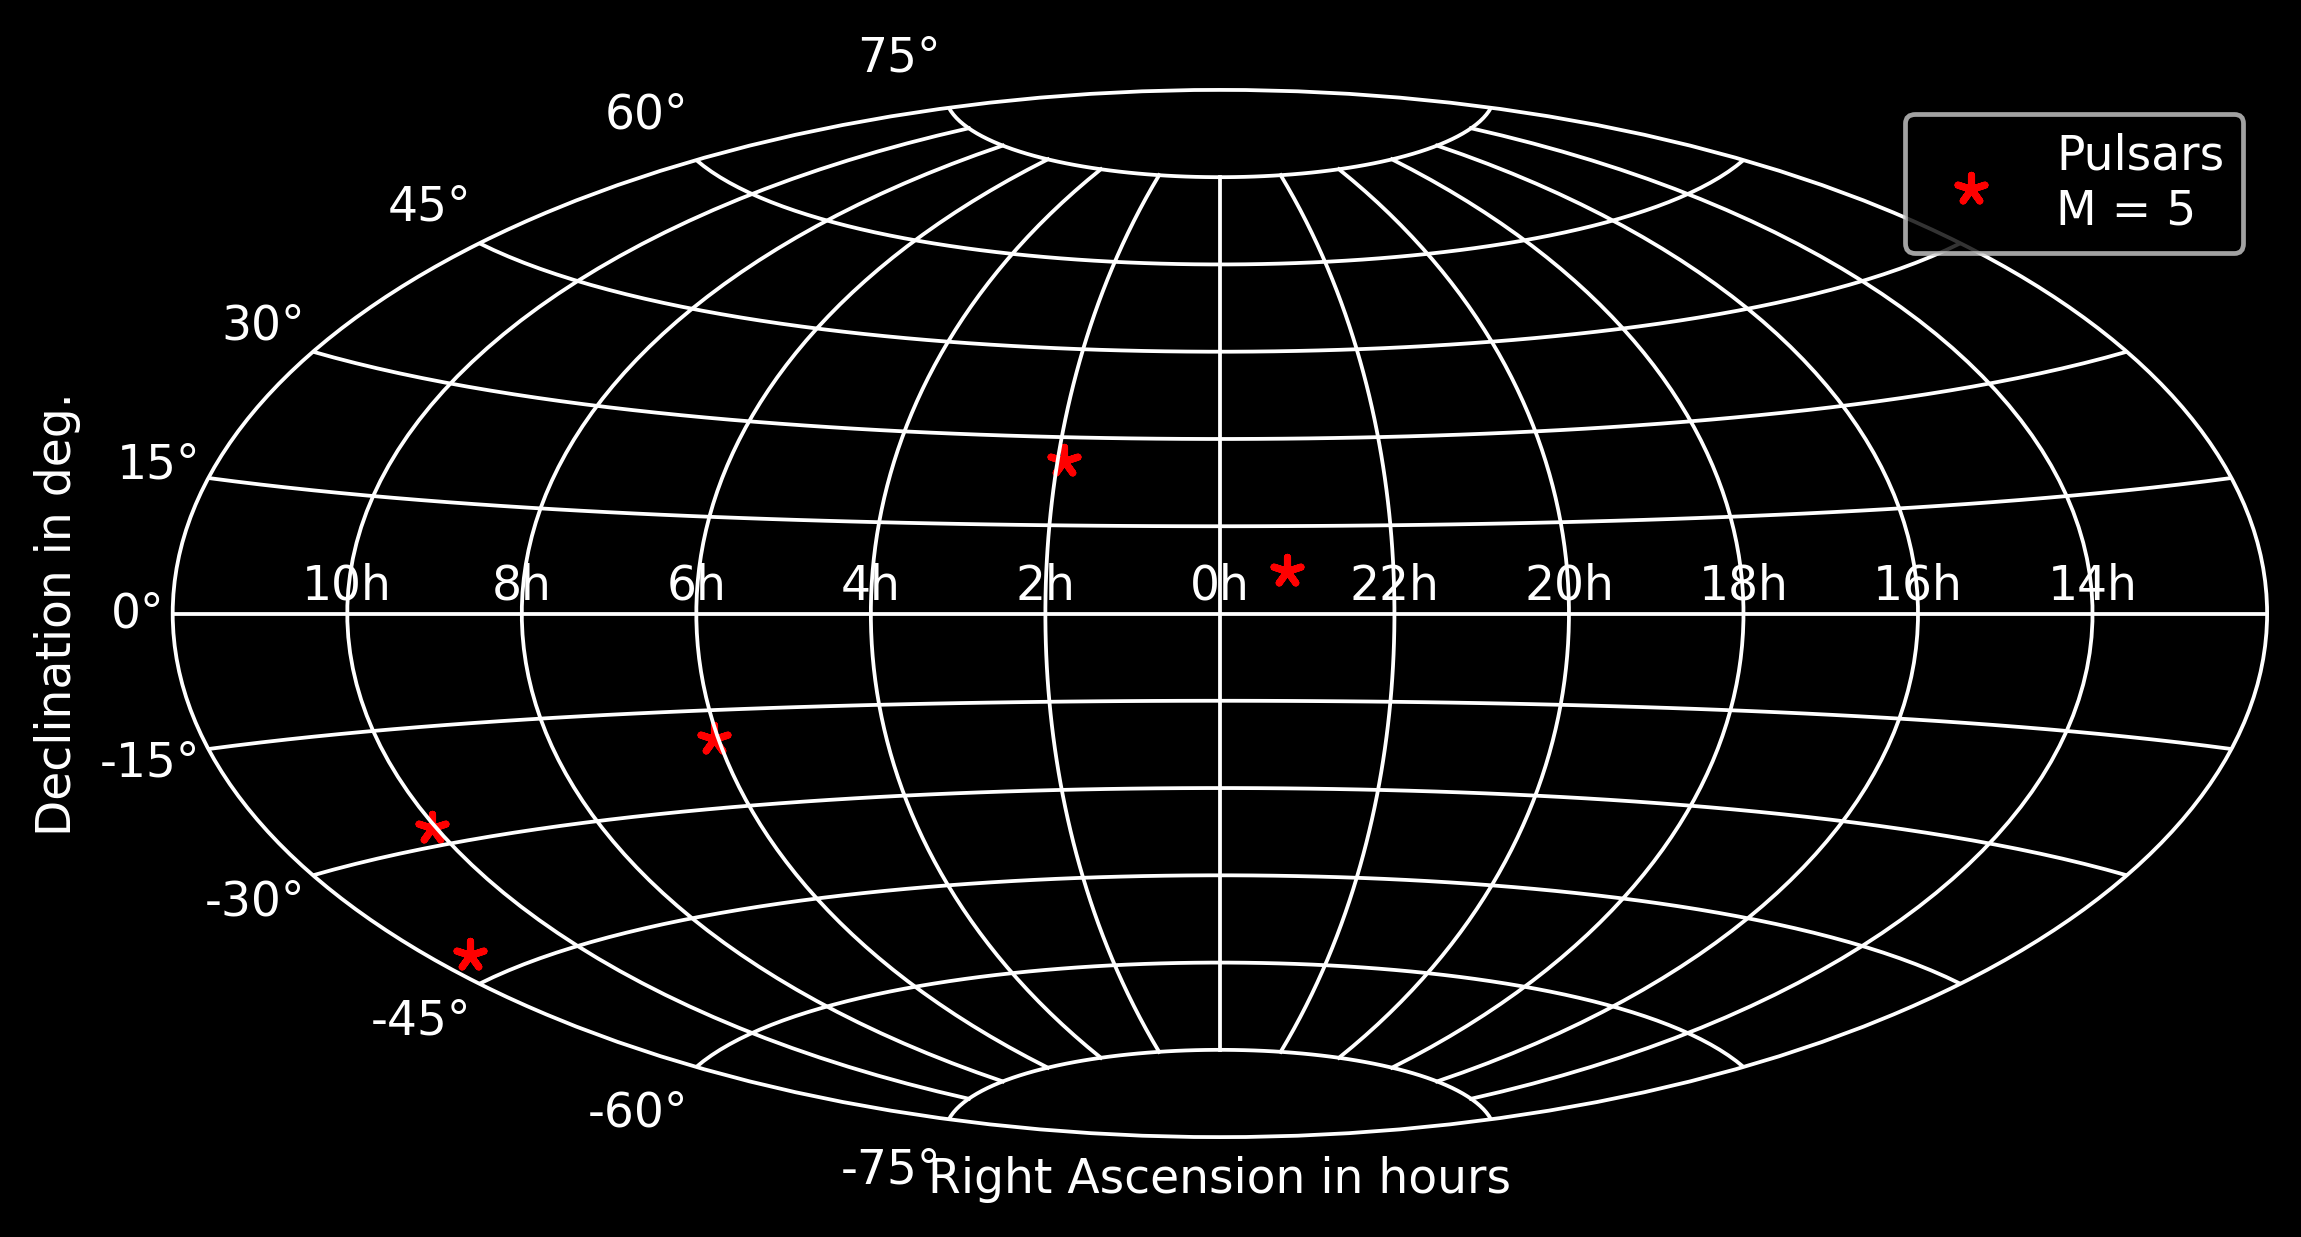

In [28]:
lam, bet, pnames, locs = sim.UniformPulsarDist(Numpulsars=Npulsars, name =True)

In [29]:
s = sim.PTASIM(MG = 'TT', 
                    psrlist = pnames,
                    toas = toas,
                    psr_locs = locs.T, 
                    Amp = np.array([gwb_amplitude]),
                    alpha = np.array([gwb_alpha]), 
                    wn_sig = wn_sig,
                    Nrea = Nrea,
                    seed = 15645789)

In [30]:
gw_res = s.total_res()

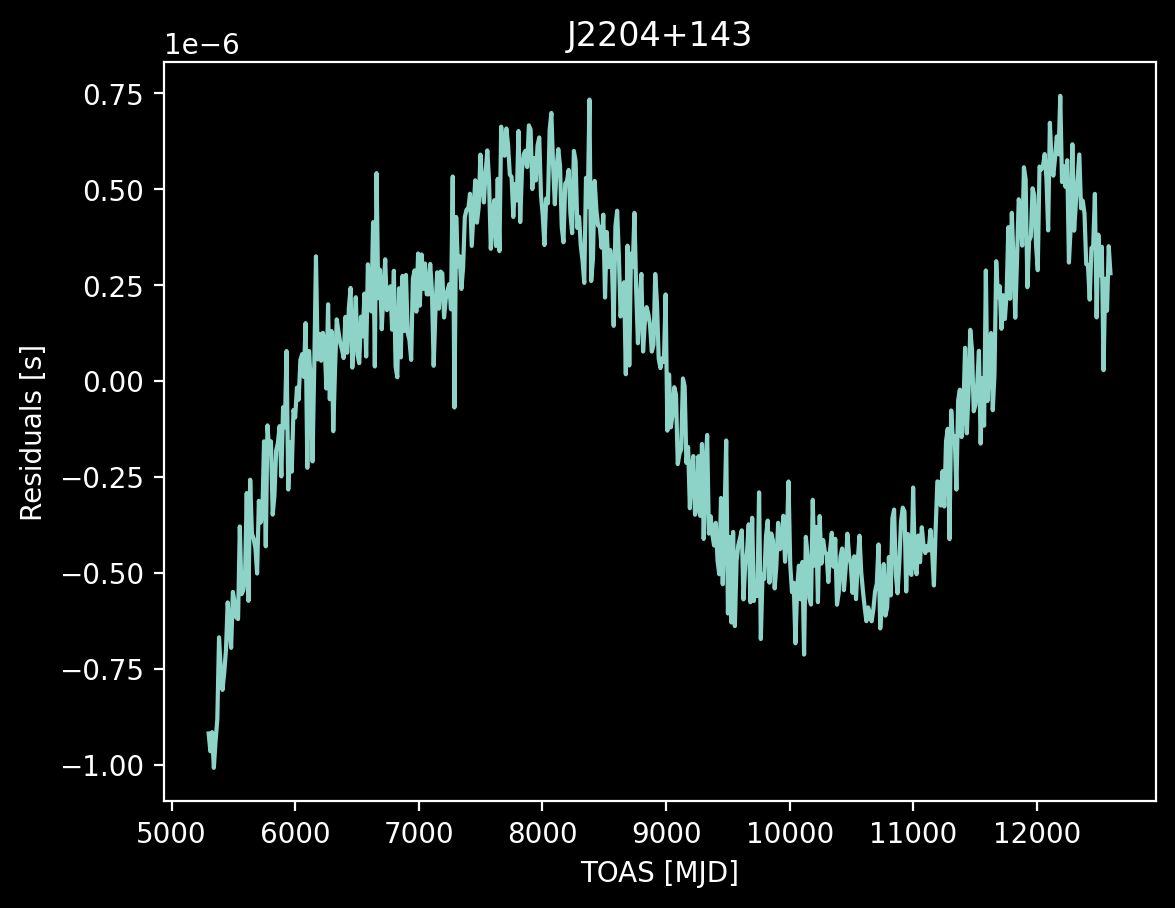

In [31]:
pidx = 3
rea = 2

plt.plot(toas[pidx], gw_res[rea][pidx])
plt.title(pnames[pidx])
plt.xlabel('TOAS [MJD]')
plt.ylabel('Residuals [s]')
plt.show()

## Single-pulsar Ananlysis Using Gibbs Sampling

In [32]:
crn_bins = 5
Gsamples = int(1e4)

In [33]:
BP = nc.BayesPower(nc.Nimapta(gw_res[rea][pidx], 
                        toas = toas[pidx], 
                        fit = False, 
                        psr_pos = locs[:, pidx],
                        wn_sigma = wn_sig),
                            crn_bins = crn_bins,
                            Baseline = observ_time,
                            inj_amp = gwb_amplitude,
                            gamma = -1 * (2 * gwb_alpha - 3),
                            num_samples = Gsamples)

In [34]:
_, rho = BP.gibbs_sampler(progress = True)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:13<00:00, 718.23it/s]


In [39]:
labs = [r'$0.5\log10\rho_{{{0}}}$'.format(_) for _ in range(1, crn_bins + 1)]
labs

['$0.5\\log10\\rho_{1}$',
 '$0.5\\log10\\rho_{2}$',
 '$0.5\\log10\\rho_{3}$',
 '$0.5\\log10\\rho_{4}$',
 '$0.5\\log10\\rho_{5}$']

## Post-processing the MCMC Output

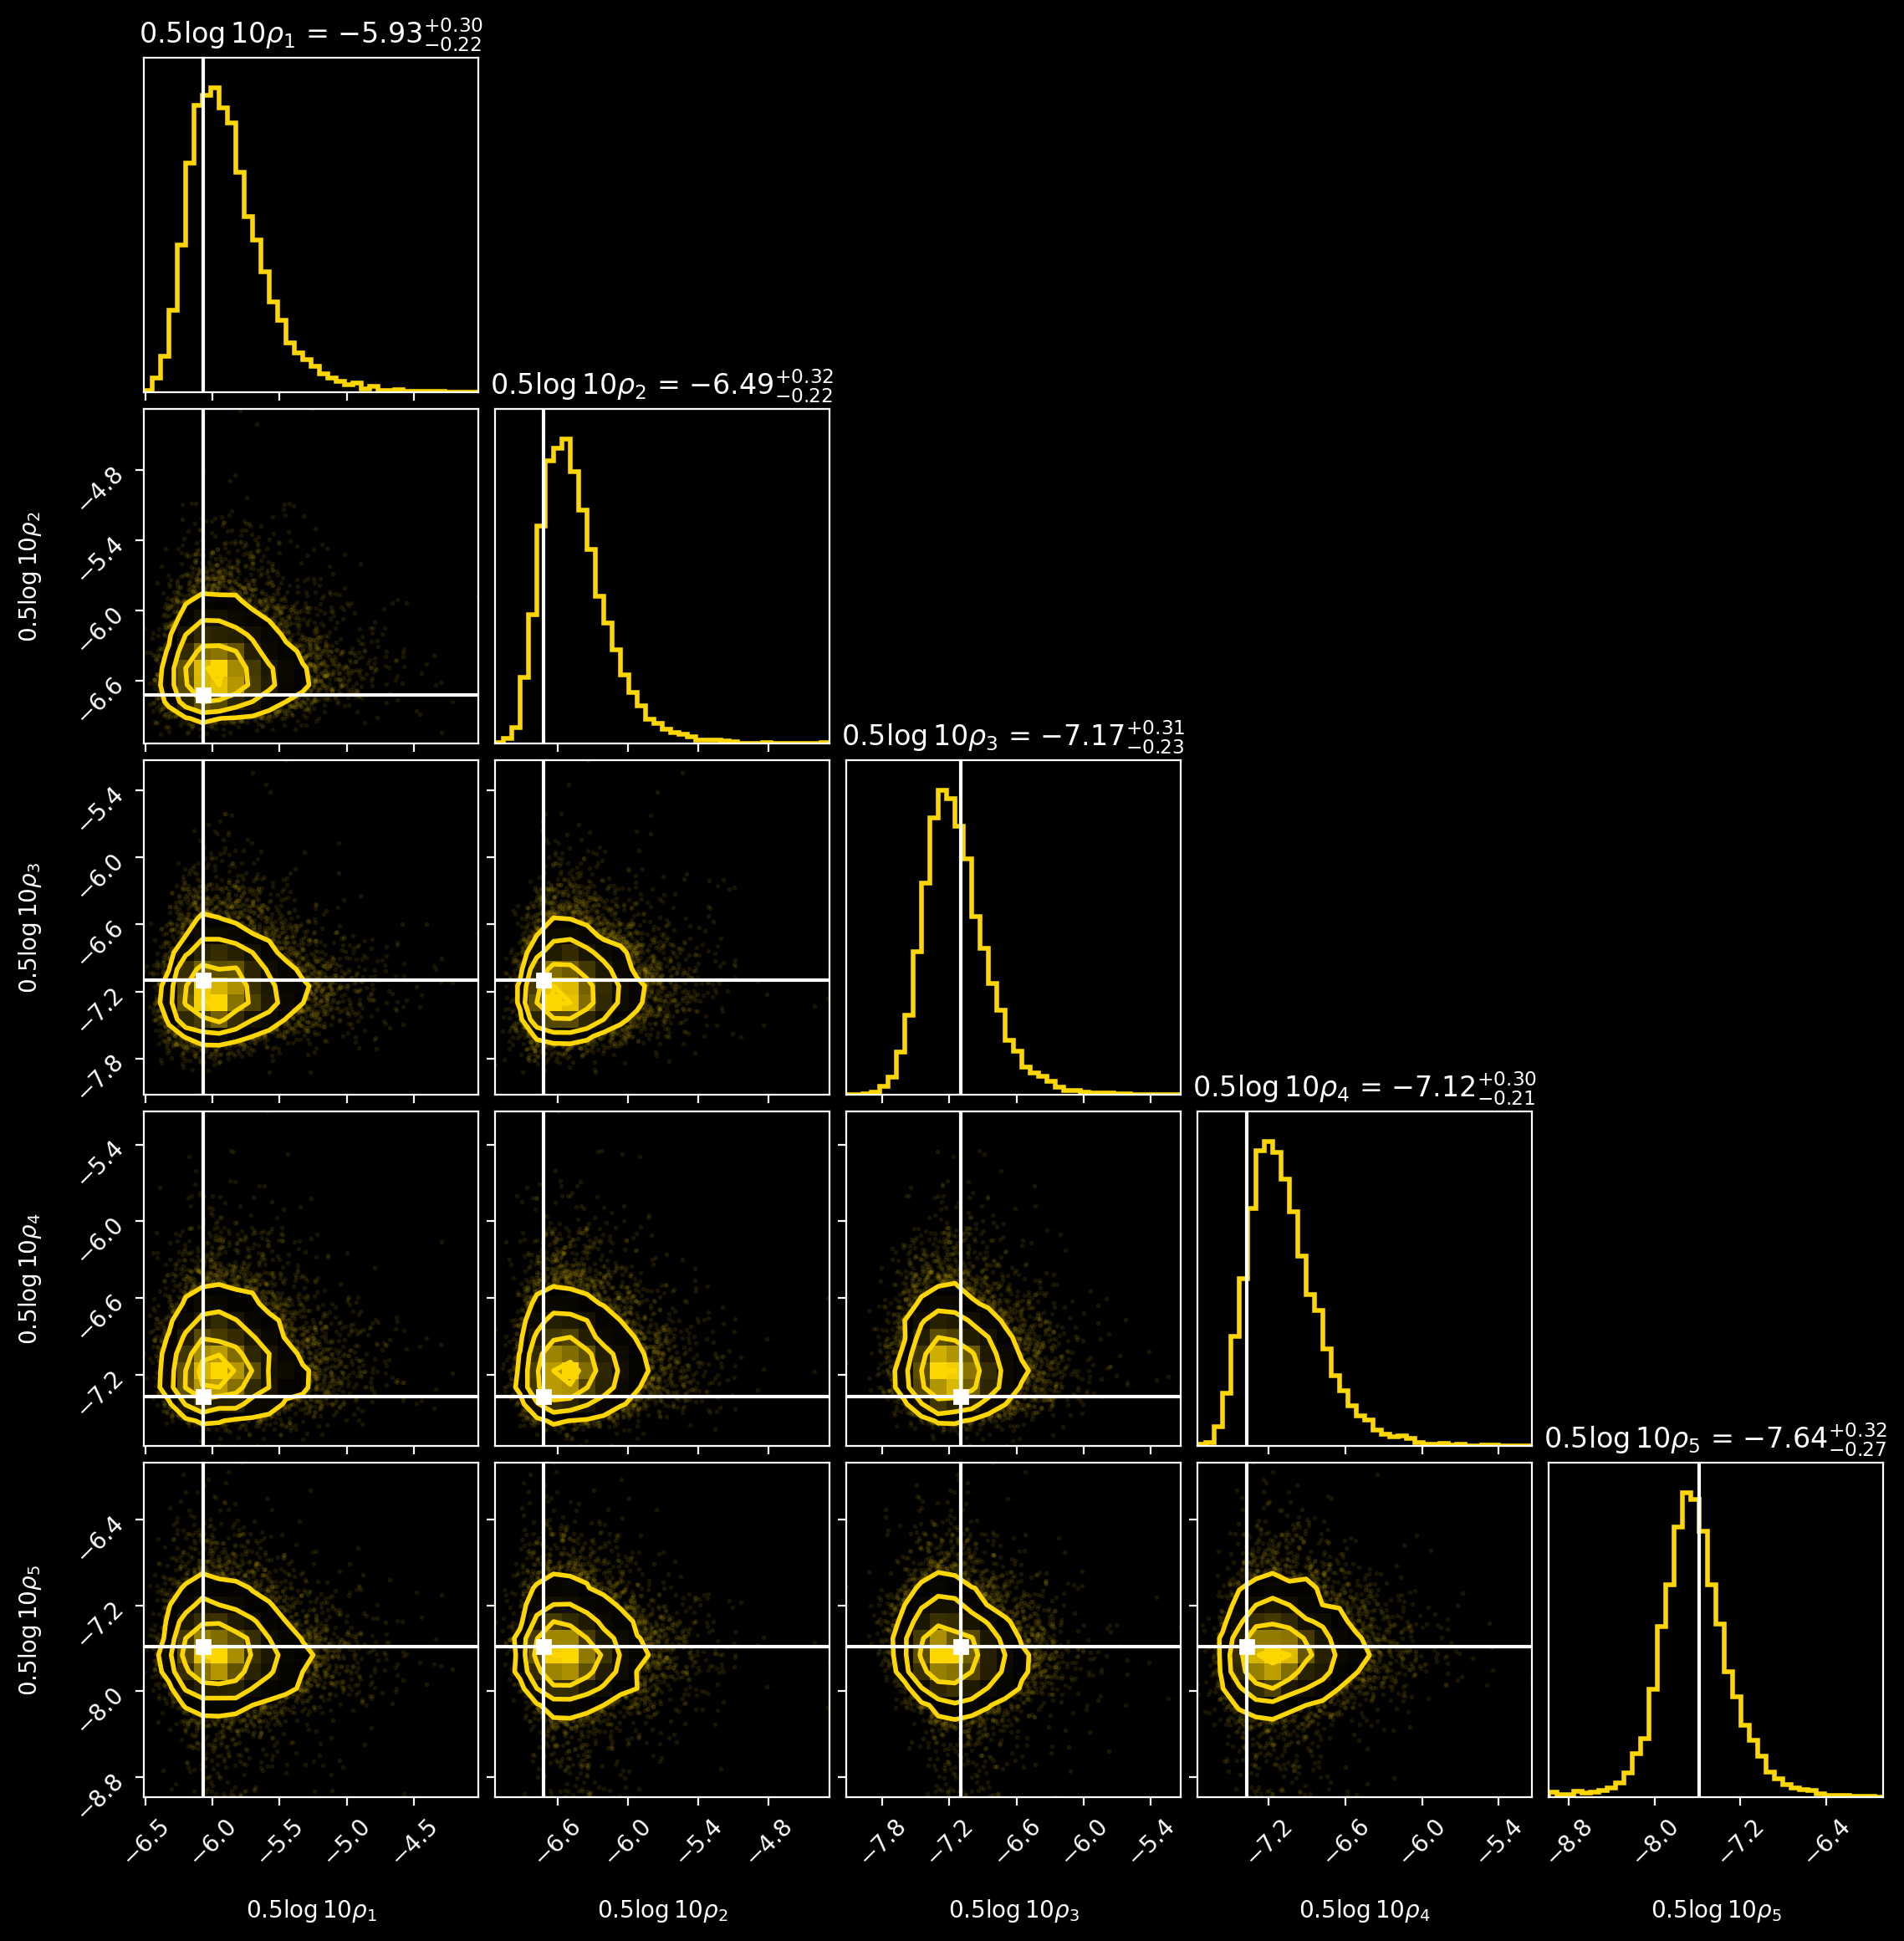

In [40]:
corner.corner(rho.T, color='gold', bins=20, hist_bin_factor=2, hist_kwargs={'density': True, 'lw':2}, 
              contour_kwargs={'linewidths':2}, labels = labs, quantile = True,show_titles = True,
              truth_color = 'white', desity = True, truths = BP.truth())
plt.show()

Make sure you know why the above plot looks how it looks!